In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 14.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=ec69e357b803d7d5d504e587840bd4a462b62fa4c05b5f861e5928c3cf2e2f03
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
%%writefile model.py


import datetime
from pathlib import Path

import joblib
import pandas as pd
import yfinance as yf
from fbprophet import Prophet

BASE_DIR = Path(__file__).resolve(strict=True).parent
TODAY = datetime.date.today()


def train(ticker="MSFT"):
    # data = yf.download("^GSPC", "2008-01-01", TODAY.strftime("%Y-%m-%d"))
    data = yf.download(ticker, "2020-01-01", TODAY.strftime("%Y-%m-%d"))
    #data.head()
    #data["Adj Close"].plot(title=f"{ticker} Stock Adjusted Closing Price")
    df_forecast = data.copy()
    df_forecast.reset_index(inplace=True)
    df_forecast["ds"] = df_forecast["Date"]
    df_forecast["y"] = df_forecast["Adj Close"]
    df_forecast = df_forecast[["ds", "y"]]
    df_forecast

    model = Prophet()
    model.fit(df_forecast)

    joblib.dump(model, Path(BASE_DIR).joinpath(f"{ticker}.pkl"))


def predict(ticker="MSFT", days=7):
    model_file = Path(BASE_DIR).joinpath(f"{ticker}.pkl")
    if not model_file.exists():
        return False

    model = joblib.load(model_file)

    future = TODAY + datetime.timedelta(days=days)

    dates = pd.date_range(start="2020-01-01", end=future.strftime("%m/%d/%Y"),)
    df = pd.DataFrame({"ds": dates})

    forecast = model.predict(df)

    model.plot(forecast).savefig(f"{ticker}_plot.png")
    model.plot_components(forecast).savefig(f"{ticker}_plot_components.png")

    return forecast.tail(days).to_dict("records")


def convert(prediction_list):
    output = {}
    for data in prediction_list:
        date = data["ds"].strftime("%m/%d/%Y")
        output[date] = data["trend"]
    return output

Writing model.py


In [4]:
from model import train, predict, convert

[*********************100%***********************]  1 of 1 completed


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


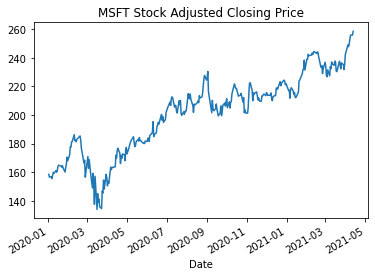

In [5]:
train()

[{'additive_terms': 1.5208274912069153,
  'additive_terms_lower': 1.5208274912069153,
  'additive_terms_upper': 1.5208274912069153,
  'ds': Timestamp('2021-04-15 00:00:00'),
  'multiplicative_terms': 0.0,
  'multiplicative_terms_lower': 0.0,
  'multiplicative_terms_upper': 0.0,
  'trend': 244.4119605685335,
  'trend_lower': 244.4119605685335,
  'trend_upper': 244.4119605685335,
  'weekly': 1.5208274912069153,
  'weekly_lower': 1.5208274912069153,
  'weekly_upper': 1.5208274912069153,
  'yhat': 245.9327880597404,
  'yhat_lower': 236.0877984476478,
  'yhat_upper': 255.58651969489193},
 {'additive_terms': 1.265486523045995,
  'additive_terms_lower': 1.265486523045995,
  'additive_terms_upper': 1.265486523045995,
  'ds': Timestamp('2021-04-16 00:00:00'),
  'multiplicative_terms': 0.0,
  'multiplicative_terms_lower': 0.0,
  'multiplicative_terms_upper': 0.0,
  'trend': 244.64326610149283,
  'trend_lower': 244.64326610149283,
  'trend_upper': 244.64326610149283,
  'weekly': 1.265486523045995

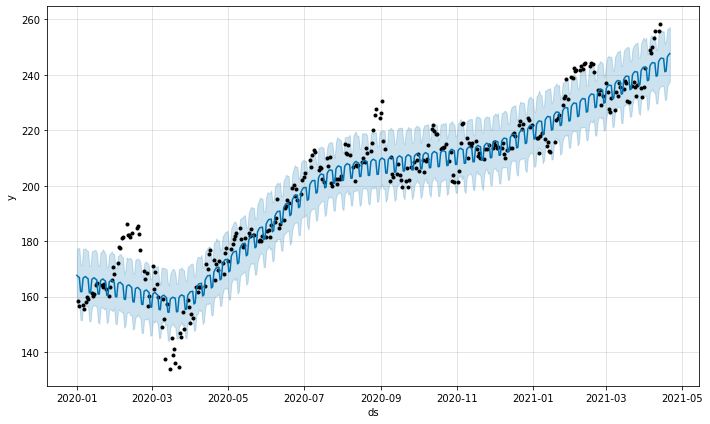

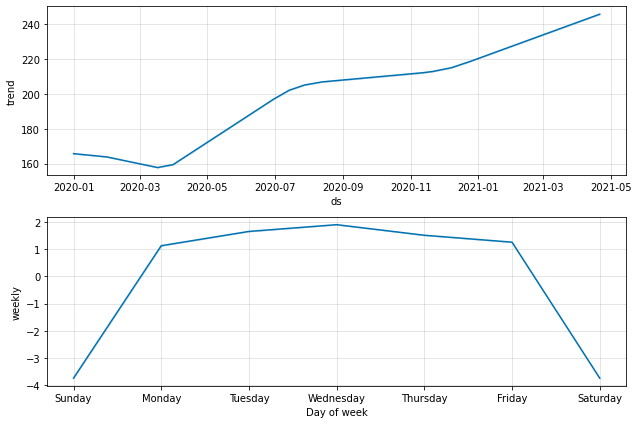

In [7]:
prediction_list = predict()
prediction_list

In [8]:
convert(prediction_list)

{'04/15/2021': 244.4119605685335,
 '04/16/2021': 244.64326610149283,
 '04/17/2021': 244.87457163445214,
 '04/18/2021': 245.1058771674115,
 '04/19/2021': 245.33718270037087,
 '04/20/2021': 245.56848823333019,
 '04/21/2021': 245.79979376628955}